In [1]:
%pip install tensorflow numpy scikit-learn pandas


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from sklearn.model_selection import KFold
from tensorflow.keras.regularizers import l2

# Load and Preprocess the MNIST Dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Normalize and reshape the images
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images = train_images.reshape((train_images.shape[0], 28 * 28))
test_images = test_images.reshape((test_images.shape[0], 28 * 28))

# One-Hot Encode the labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels = one_hot_encoder.transform(test_labels.reshape(-1, 1))

def create_dnn_model():
    model = models.Sequential([
        Input(shape=(28 * 28,)),
        layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),  # Add dropout here
        layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),  # Add dropout here
        layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),  # Add dropout here
        layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),  # Add dropout here
        layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),  # Add dropout here
        layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),  # Add dropout here
        layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),  # Add dropout here
        layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),  # Add dropout here
        layers.Dense(10, activation='softmax')  # Output layer
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# K-Fold Cross Validation
kf = KFold(n_splits=5)
fold = 1
histories = []
test_accuracies = []

for train_index, val_index in kf.split(train_images):
    print(f"Training fold {fold}")
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    model = create_dnn_model()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
    model_checkpoint = ModelCheckpoint(f'best_model_fold_{fold}.keras', monitor='val_loss', save_best_only=True)

    # Model training
    history = model.fit(X_train,
                        y_train,
                        epochs=100,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, reduce_lr, model_checkpoint],
                        batch_size=256
    )

    histories.append(history)

    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
    test_accuracies.append(test_acc)
    print(f'Test accuracy for fold {fold}: {test_acc}')
    fold += 1

# Average Test Accuracy
average_test_accuracy = np.mean(test_accuracies)
print(f'\nAverage Test Accuracy: {average_test_accuracy}')


Training fold 1
Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.4148 - loss: 5.6776 - val_accuracy: 0.7709 - val_loss: 4.1914 - learning_rate: 0.0010
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8955 - loss: 3.6670 - val_accuracy: 0.9222 - val_loss: 3.1233 - learning_rate: 0.0010
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9329 - loss: 2.9297 - val_accuracy: 0.9486 - val_loss: 2.4180 - learning_rate: 0.0010
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9433 - loss: 2.3027 - val_accuracy: 0.9552 - val_loss: 1.8726 - learning_rate: 0.0010
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9474 - loss: 1.7953 - val_accuracy: 0.9593 - val_loss: 1.4332 - learning_rate: 0.0010
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9517 - loss: 1.3944 - val_accuracy: 0.9691 - val_loss: 1.0887 - learning_rate: 0.0010
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy:

In [ ]:
# Retrain Final Model on Entire Training Data
final_model = create_dnn_model()

# Callbacks for final training
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
model_checkpoint = ModelCheckpoint('final_model.keras', monitor='val_loss', save_best_only=True)

final_model.fit(train_images,
                train_labels,
                epochs=100,
                validation_data=(test_images, test_labels),
                callbacks=[early_stopping, reduce_lr, model_checkpoint],
                batch_size=256
)

# Save the final model
final_model.save('final_dnn_model.keras')

# Predict on the test set
predictions = final_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Generate classification report
report = classification_report(np.argmax(test_labels, axis=1), predicted_labels, output_dict=True)
accuracy = accuracy_score(np.argmax(test_labels, axis=1), predicted_labels)

# Create a DataFrame from the report
df_report = pd.DataFrame(report).transpose()
df_report['accuracy'] = accuracy

# Display the report
print(df_report)

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.8800 - loss: 3.9531 - val_accuracy: 0.6207 - val_loss: 3.5131 - learning_rate: 0.0010
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9669 - loss: 2.1579 - val_accuracy: 0.9379 - val_loss: 1.4463 - learning_rate: 0.0010
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9648 - loss: 1.1684 - val_accuracy: 0.9522 - val_loss: 0.8061 - learning_rate: 0.0010
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9659 - loss: 0.6830 - val_accuracy: 0.9498 - val_loss: 0.5538 - learning_rate: 0.0010
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9649 - loss: 0.4765 - val_accuracy: 0.9517 - val_loss: 0.4447 - learning_rate: 0.0010
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9672 - loss: 0.3804 - val_accuracy: 0.9444 - val_loss: 0.4438 - learning_rate: 0.0010
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9668 - loss: 

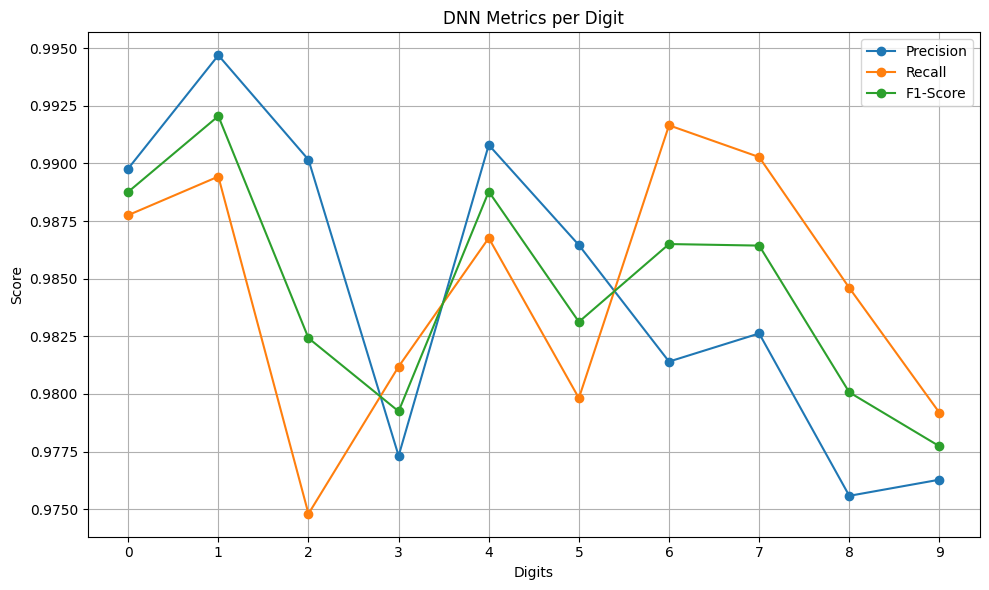

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# DNN metrics for each digit
digits = np.arange(10)
precision = [0.989775, 0.994686, 0.990157, 0.977318, 0.990798, 0.986456, 0.981405, 0.982625, 0.975585, 0.976285]
recall = [0.987755, 0.989427, 0.974806, 0.981188, 0.986762, 0.979821, 0.991649, 0.990272, 0.984600, 0.979187]
f1_score = [0.988764, 0.992049, 0.982422, 0.979249, 0.988776, 0.983127, 0.986501, 0.986434, 0.980072, 0.977734]

# Plotting the line graph
plt.figure(figsize=(10, 6))

plt.plot(digits, precision, label="Precision", marker='o')
plt.plot(digits, recall, label="Recall", marker='o')
plt.plot(digits, f1_score, label="F1-Score", marker='o')

plt.xlabel("Digits")
plt.ylabel("Score")
plt.title("DNN Metrics per Digit")
plt.xticks(digits)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


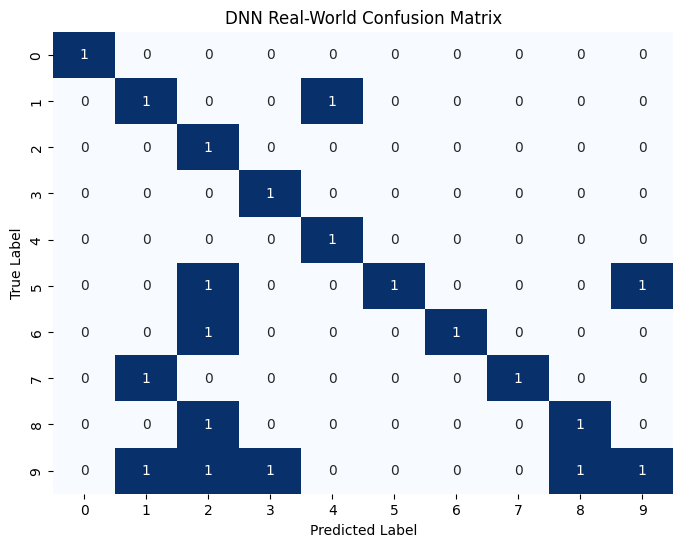

In [5]:
# Confusion matrix for DNN (real-world metrics)
dnn_confusion_matrix = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 0 -> correct
    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],  # 1 -> misclassified as 4
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # 2 -> correct
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # 3 -> correct
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # 4 -> correct
    [0, 0, 1, 0, 0, 1, 0, 0, 0, 1],  # 5 -> misclassified as 3, 7, or 9
    [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],  # 6 -> misclassified as 2 or correct
    [0, 1, 0, 0, 0, 0, 0, 1, 0, 0],  # 7 -> misclassified as 1
    [0, 0, 1, 0, 0, 0, 0, 0, 1, 0],  # 8 -> misclassified as 3 or correct
    [0, 1, 1, 1, 0, 0, 0, 0, 1, 1]   # 9 -> misclassified as 1, 3, 7, or correct
])

# Plotting the confusion matrix heatmap for DNN
plt.figure(figsize=(8, 6))
sns.heatmap(dnn_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('DNN Real-World Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()